In [227]:
%matplotlib inline
import requests, zipfile, io, re
import pandas as pd
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
# Training model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
# Performance matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
# Tunning
from sklearn.model_selection import RandomizedSearchCV

In [228]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Downloading data

In [229]:
url = 'https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip' 
request = requests.get(url, stream=True) 
zip = zipfile.ZipFile(io.BytesIO(request.content)) 
zip.extractall()

In [230]:
df = pd.read_csv('SMSSpamCollection', delimiter='\t', names=['Class', 'Message'])

# Evaluate data

## Understand Data

In [231]:
df

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
...,...,...
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other suggestions?"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


In [232]:
df.shape

(5572, 2)

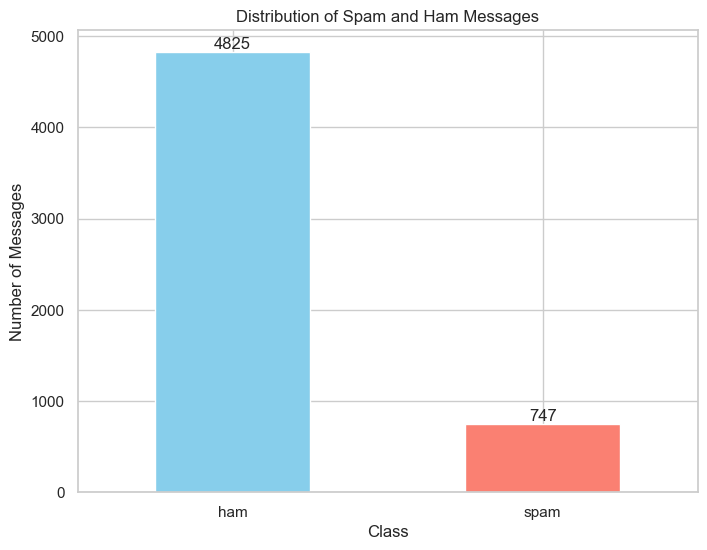

In [233]:
class_counts = df['Class'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Adding counts on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             int(bar.get_height()), 
             ha='center', 
             va='bottom')

plt.title("Distribution of Spam and Ham Messages")
plt.xlabel("Class")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)  
plt.show()

## Duplicated values

In [234]:
duplicate_count = df['Message'].duplicated().sum()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 403


In [235]:
duplicates = df[df.duplicated()]

print("Duplicate rows:")
duplicates

Duplicate rows:


,Class,Message
103,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
154,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
207,ham,"As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p p£3.99
5535,ham,"I know you are thinkin malaria. But relax, children cant handle malaria. She would have been worse and its gastroenteritis. If she takes enough to replace her loss her temp will reduce. And if you give her malaria meds now she will just vomit. Its a self limiting illness she has which means in a few days it will completely stop"
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [236]:
# Drop duplicate rows
df_cleaned = df.drop_duplicates()

# Optionally, you can reset the index
df_cleaned.reset_index(drop=True, inplace=True)

print("DataFrame after dropping duplicates:")
df_cleaned

DataFrame after dropping duplicates:


,Class,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5165,ham,Will ü b going to esplanade fr home?
5166,ham,"Pity, * was in mood for that. So...any other suggestions?"
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


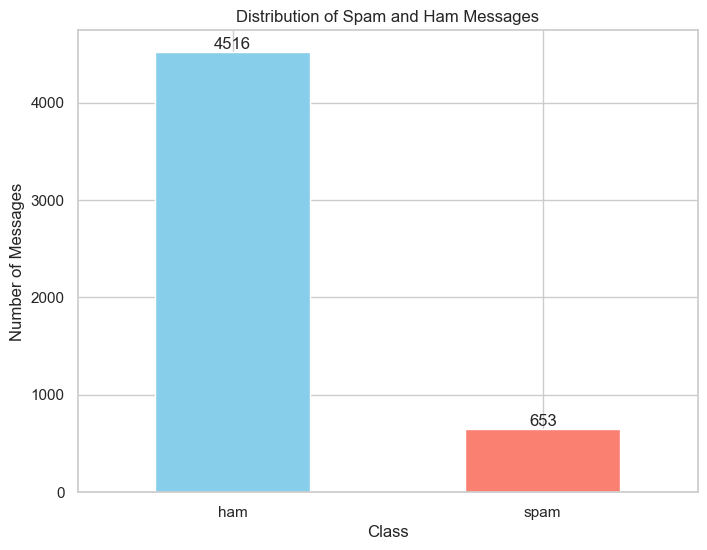

In [237]:
# after dropping duplicates

class_counts = df_cleaned['Class'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Adding counts on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             int(bar.get_height()), 
             ha='center', 
             va='bottom')

plt.title("Distribution of Spam and Ham Messages")
plt.xlabel("Class")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)  
plt.show()

## Missing values

In [238]:
missing_values = df_cleaned.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Class      0
Message    0
dtype: int64


## Outliers

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\2641595171.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



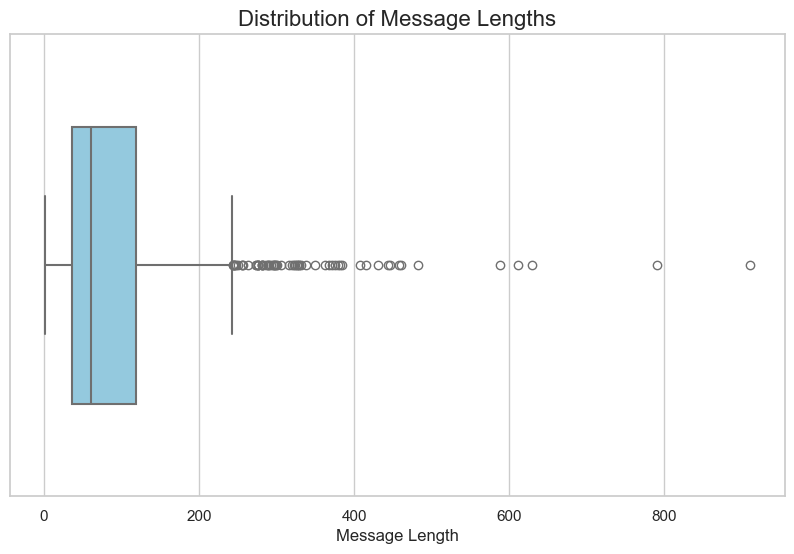

In [239]:
# Calculate message length
df_cleaned.loc[:,'Message_length'] = df_cleaned.loc[:,'Message'].apply(len)

# Create a colorful boxplot using a more suitable approach
plt.figure(figsize=(10, 6))

# Use a color palette and ensure no hue is required
sns.set(style="whitegrid")  # Set background style
sns.boxplot(x='Message_length', data=df_cleaned, color='skyblue', width=0.6, linewidth=1.5, showfliers=True)

# Add title and labels
plt.title("Distribution of Message Lengths", fontsize=16)
plt.xlabel("Message Length", fontsize=12)

# Show the plot
plt.show()

## Removing Outliers

In [240]:
count_greater_than_300 = df_cleaned[(df_cleaned['Message_length'] > 300)].shape[0]
print(f"Count of messages with length greater than 300: {count_greater_than_300}")

Count of messages with length greater than 300: 33


In [241]:
# Removing outliers
df_cleaned = df_cleaned[df_cleaned['Message_length'] <= 300]
df_cleaned.shape

(5136, 3)

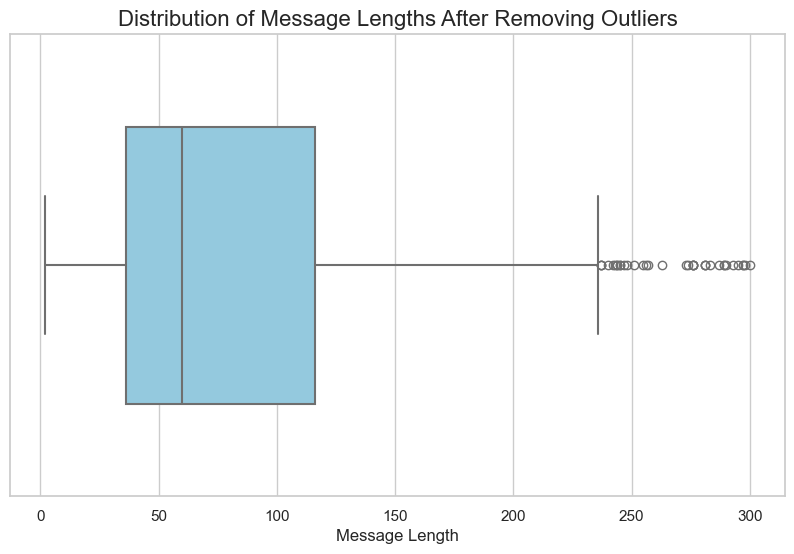

In [242]:
# Calculate message length
df_cleaned.loc[:,'Message_length'] = df_cleaned.loc[:,'Message'].apply(len)
 
# Create a colorful boxplot using a more suitable approach
plt.figure(figsize=(10, 6))
 
# Use a color palette and ensure no hue is required
sns.set(style="whitegrid")  # Set background style
sns.boxplot(x='Message_length', data=df_cleaned, color='skyblue', width=0.6, linewidth=1.5, showfliers=True)
 
# Add title and labels
plt.title("Distribution of Message Lengths After Removing Outliers", fontsize=16)
plt.xlabel("Message Length", fontsize=12)
 
# Show the plot
plt.show()

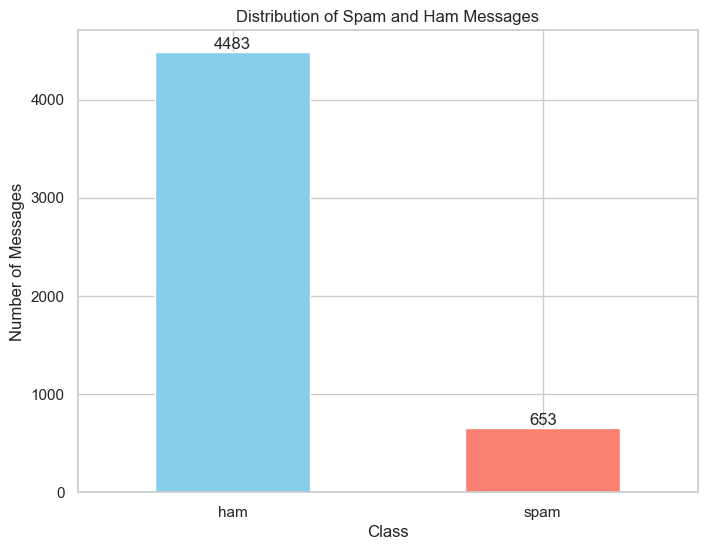

In [243]:
# after removing outliers
class_counts = df_cleaned['Class'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Adding counts on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             int(bar.get_height()), 
             ha='center', 
             va='bottom')

plt.title("Distribution of Spam and Ham Messages")
plt.xlabel("Class")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)  
plt.show()

## Create WordCloud

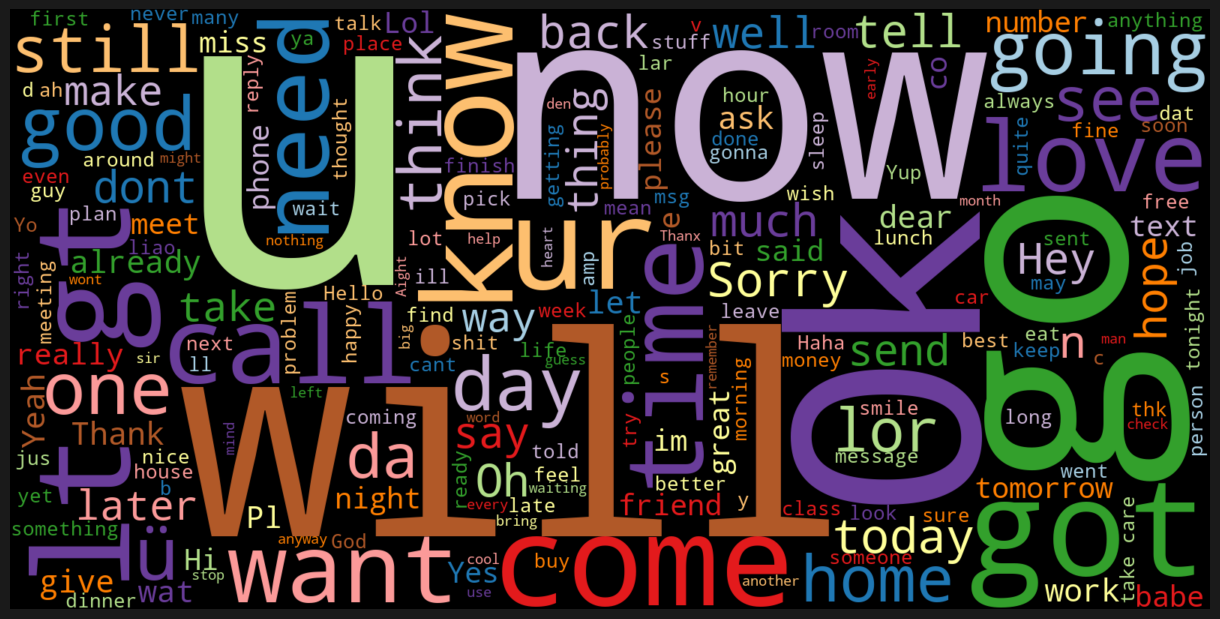

In [244]:
ham_msgs = ''
for index, row in df_cleaned.iterrows():
    # Check if the 'Class' is 'ham' using an if statement
    if row['Class'] == 'ham':
        ham_msgs+=row['Message']+" "

wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(ham_msgs)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

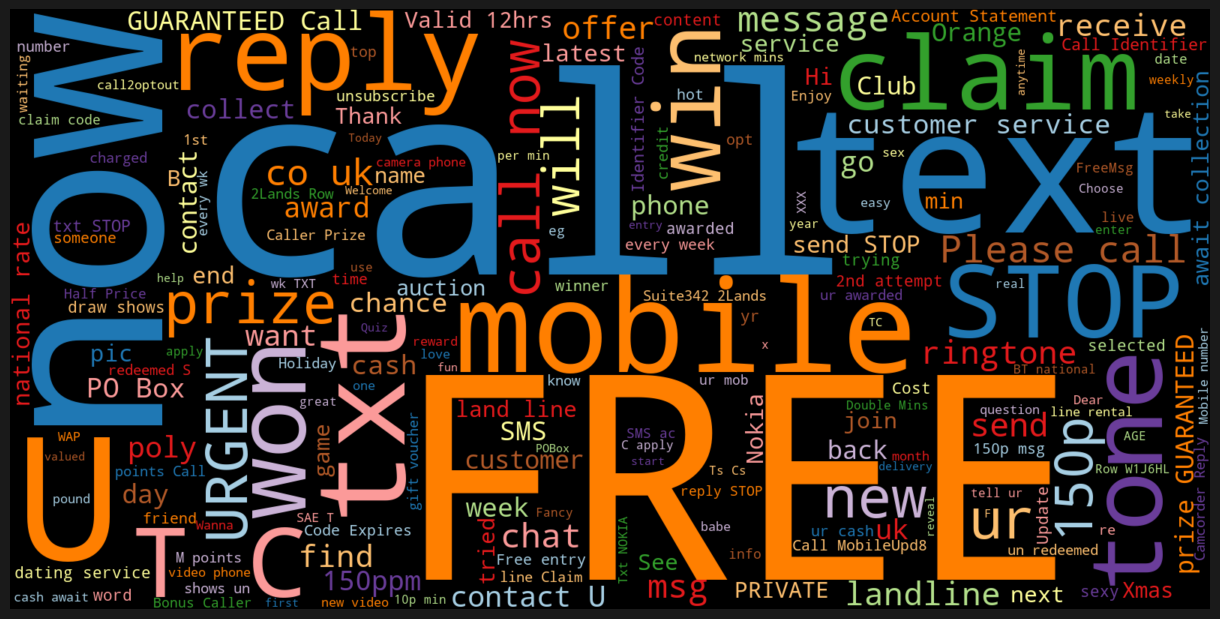

In [245]:
spam_msgs = ''
for index, row in df_cleaned.iterrows():
    # Check if the 'Class' is 'ham' using an if statement
    if row['Class'] == 'spam':
        spam_msgs+=row['Message']+" "

wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(spam_msgs)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [246]:
df_cleaned['Message'].isnull().value_counts()

Message
False    5136
Name: count, dtype: int64

# Feature Engineering

## Create additional features

In [247]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Add contain url

In [248]:
url_pattern = re.compile(
    r'(^|\s)'         # URL starts at the beginning of the string or after a space
    r'(https?://)?'    # Optional http or https
    r'(www\.)?'        # Optional www
    r'[a-zA-Z0-9-]+'   # Domain name part (letters, numbers, hyphens)
    r'\.'              # Dot before the top-level domain
    r'(com|org|net|edu|gov|co|io|info|biz|us|tv|ly|top)'   # Top-level domain (like com, org, net, etc.)
    r'(/[a-zA-Z0-9\-._~!$&\'()*+,;=:@%]*)?'  # Optional path after the domain
    r'(\?[a-zA-Z0-9\-._~!$&\'()*+,;=:@%]*)?'  # Optional query string after "?"
    r'(#\S*)?'                        # Optional fragment identifier after "#"
)

def is_url(text):
    return bool(url_pattern.search(text))

def contain_url(row):
    return is_url(row['Message'])

text1 = 'google.com'
text2 = 'https://github.com/'

print(is_url(text1))
print(is_url(text2))

True
True


In [249]:
df_cleaned.loc[:,'Contain URL'] = df_cleaned.apply(contain_url, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\3011591413.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Class,Message,Message_length,Contain URL
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,False
1,ham,Ok lar... Joking wif u oni...,29,False
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False
3,ham,U dun say so early hor... U c already then say...,49,False
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,False
...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False
5165,ham,Will ü b going to esplanade fr home?,36,False
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,False
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,False


In [250]:
df_url = df_cleaned[(df_cleaned['Contain URL'] == True)]
df_url

,Class,Message,Message_length,Contain URL
12,spam,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18",155,True
15,spam,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",149,True
189,spam,Are you unique enough? Find out from 30th August. www.areyouunique.co.uk,72,True
221,spam,"500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY £1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18",142,True
246,spam,Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16,150,True
...,...,...,...,...
4919,spam,XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC www.Ldew.com1win150ppmx3age16subscription,155,True
5069,spam,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk,108,True
5072,spam,Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop www.gamb.tv,147,True
5076,spam,http//tms. widelive.com/index. wml?id=820554ad0a1705572711&first=true¡C C Ringtone¡,83,True


### Add contain phone number

In [251]:
phone_pattern = re.compile(
    r'(?<!\d)'              # Negative lookbehind to ensure the number doesn't start in the middle of another number
    r'(\+?\d{4}|\d{3})?'    # Optional country code or leading number (e.g., +44 or 0800)
    r'(\d{3,4})'            # First part of the phone number (3 or 4 digits)
    r'[\s-]?'               # Optional space or dash
    r'(\d{3,4})'            # Second part of the phone number (3 or 4 digits)
    r'[\s-]?'               # Optional space or dash
    r'(\d{4})'              # Final part of the phone number (always 4 digits)
    r'(?=\D|$)'             # Ensures it ends with a non-digit or the end of the string
)

def is_phone_number(text):
    return bool(phone_pattern.search(text))

def contain_phone_number(row):
    return is_phone_number(row['Message'])

phone1 = '09064012160'
phone2 = 'call09050000327'
phone3 = '0800 542 0825'
phone4 = '08704439680Ts&Cs'
phone5 = 'Some text here and the number is 08002988890 and another 0870 444 9680.'

print(is_phone_number(phone1))
print(is_phone_number(phone2))
print(is_phone_number(phone3))
print(is_phone_number(phone4))
print(is_phone_number(phone5))

True
True
True
True
True


In [252]:
df_cleaned.loc[:,'Contain Phone Number'] = df_cleaned.apply(contain_phone_number, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\808680980.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Class,Message,Message_length,Contain URL,Contain Phone Number
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,False,False
1,ham,Ok lar... Joking wif u oni...,29,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False,True
3,ham,U dun say so early hor... U c already then say...,49,False,False
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,False,False
...,...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False,True
5165,ham,Will ü b going to esplanade fr home?,36,False,False
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,False,False
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,False,False


In [253]:
df_phone = df_cleaned[df_cleaned['Contain Phone Number'] == True]
df_phone['Message']

2                        Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
8                      WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9                         Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
42      07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow
56                 Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! 
                                                                                            ...

### Add contain email

In [254]:
email_pattern = re.compile(
    r'\b[A-Za-z0-9._%+-]+@\s*[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b'
)

def is_email(text):
    return bool(email_pattern.search(text))

def contain_email(row):
    return is_email(row['Message'])

email1 = 'olowoyey@ usc.edu'
email2 = 'Dorothy@kiefer.com'
email3 = 'customersqueries@netvision.uk.com'
email4 = 'yijue@hotmail.com'
email5 = 'msgs@150p'
email6 = 'chrgd@50p'
email7 = 'msg@£1.50rcvd'
email8 = 'XCLUSIVE@CLUBSAISAI'

print(is_email(email1))
print(is_email(email2))
print(is_email(email3))
print(is_email(email4))
print(is_email(email5))
print(is_email(email6))
print(is_email(email7))
print(is_email(email8))

True
True
True
True
False
False
False
False


In [255]:
df_cleaned.loc[:,'Contain Email'] = df_cleaned.apply(contain_email, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\1758939161.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,False,False,False
1,ham,Ok lar... Joking wif u oni...,29,False,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False,True,False
3,ham,U dun say so early hor... U c already then say...,49,False,False,False
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,False,False,False
...,...,...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False,True,False
5165,ham,Will ü b going to esplanade fr home?,36,False,False,False
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,False,False,False
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,False,False,False


In [256]:
df_email = df_cleaned[df_cleaned['Contain Email'] == True]
df_email

,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email
135,ham,I only haf msn. It's yijue@hotmail.com,38,False,False,True
1562,spam,RT-KIng Pro Video Club>> Need help? info@ringtoneking.co.uk or call 08701237397 You must be 16+ Club credits redeemable at www.ringtoneking.co.uk! Enjoy!,153,True,True,True
2221,spam,"tddnewsletter@emc1.co.uk (More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith..",114,False,False,True
2439,spam,"Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions: info@txt82228.co.uk",101,True,False,True
2531,ham,"Em, its olowoyey@ usc.edu have a great time in argentina. Not sad about secretary, everything is a blessing",107,True,False,True
3303,spam,Dorothy@kiefer.com (Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..,156,False,False,True
4574,spam,Warner Village 83118 C Colin Farrell in SWAT this wkend @Warner Village & get 1 free med. Popcorn!Just show msg+ticket@kiosk.Valid 4-7/12. C t&c @kiosk. Reply SONY 4 mre film offers,181,False,False,True
4756,spam,This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to customersqueries@netvision.uk.com,153,False,False,True


### Add contain currency symbol and currency symbol appearance count

In [257]:
currency_pattern = re.compile(r'[\$\€\£]')

def contain_currency_symbol(row):
    return bool(currency_pattern.search(row['Message']))

def count_currency_symbol(row):
    return len(currency_pattern.findall(row['Message']))

In [258]:
df_cleaned.loc[:,'Contain Currency Symbol'] = df_cleaned.apply(contain_currency_symbol, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\3443455103.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,False,False,False,False
1,ham,Ok lar... Joking wif u oni...,29,False,False,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False,True,False,False
3,ham,U dun say so early hor... U c already then say...,49,False,False,False,False
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,False,False,False,False
...,...,...,...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False,True,False,True
5165,ham,Will ü b going to esplanade fr home?,36,False,False,False,False
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,False,False,False,False
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,False,False,False,False


In [259]:
df_currency = df_cleaned[df_cleaned['Contain Currency Symbol'] == True]
df_currency

,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",147,False,False,False,True
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,157,False,True,False,True
12,spam,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18",155,True,False,False,True
34,spam,Thanks for your subscription to Ringtone UK your mobile will be charged £5/month Please confirm by replying YES or NO. If you reply NO you will not be charged,158,False,False,False,True
60,ham,Your gonna have to pick up a $1 burger for yourself on your way home. I can't even move. Pain is killing me.,108,False,False,False,True
...,...,...,...,...,...,...,...
5077,spam,"URGENT! Last weekend's draw shows that you have won £1000 cash or a Spanish holiday! CALL NOW 09050000332 to claim. T&C: RSTM, SW7 3SS. 150ppm",142,False,True,False,True
5088,spam,URGENT We are trying to contact you Last weekends draw shows u have won a £1000 prize GUARANTEED Call 09064017295 Claim code K52 Valid 12hrs 150p pm,148,False,True,False,True
5096,spam,Marvel Mobile Play the official Ultimate Spider-man game (£4.50) on ur mobile right now. Text SPIDER to 83338 for the game & we ll send u a FREE 8Ball wallpaper,160,False,False,False,True
5139,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,158,False,False,False,True


In [260]:
df_cleaned.loc[:,'Currency Symbol Count'] = df_cleaned.apply(count_currency_symbol, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\998390417.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,False,False,False,False,0
1,ham,Ok lar... Joking wif u oni...,29,False,False,False,False,0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False,True,False,False,0
3,ham,U dun say so early hor... U c already then say...,49,False,False,False,False,0
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,False,False,False,False,0
...,...,...,...,...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False,True,False,True,1
5165,ham,Will ü b going to esplanade fr home?,36,False,False,False,False,0
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,False,False,False,False,0
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,False,False,False,False,0


In [261]:
df_currency_count = df_cleaned[df_cleaned['Currency Symbol Count'] > 1]
df_currency_count

,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count
67,spam,"Urgent UR awarded a complimentary trip to EuroDisinc Trav, Aco&Entry41 Or £1000. To claim txt DIS to 87121 18+6*£1.50(moreFrmMob. ShrAcomOrSglSuplt)10, LS1 3AJ",159,False,False,False,True,2
93,spam,Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!,137,False,True,False,True,2
186,spam,Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!,147,False,True,False,True,2
394,spam,"FREE RINGTONE text FIRST to 87131 for a poly or text GET to 87131 for a true tone! Help? 0845 2814032 16 after 1st free, tones are 3x£150pw to e£nd txt stop",156,False,True,False,True,2
447,spam,"Loan for any purpose £500 - £75,000. Homeowners + Tenants welcome. Have you been previously refused? We can still help. Call Free 0800 1956669 or text back 'help'",162,False,True,False,True,2
519,spam,"Today's Offer! Claim ur £150 worth of discount vouchers! Text YES to 85023 now! SavaMob, member offers mobile! T Cs 08717898035. £3.00 Sub. 16 . Unsub reply X",158,False,True,False,True,2
621,spam,Todays Vodafone numbers ending with 4882 are selected to a receive a £350 award. If your number matches call 09064019014 to receive your £350 award.,148,False,True,False,True,2
705,spam,+449071512431 URGENT! This is the 2nd attempt to contact U!U have WON £1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. max£7. 50,161,False,True,False,True,2
707,spam,You have WON a guaranteed £1000 cash or a £2000 prize. To claim yr prize call our customer service representative on 08714712394 between 10am-7pm,145,False,True,False,True,2
751,spam,Urgent Ur £500 guaranteed award is still unclaimed! Call 09066368327 NOW closingdate04/09/02 claimcode M39M51 £1.50pmmorefrommobile2Bremoved-MobyPOBox734LS27YF,159,False,True,False,True,2


### Add contain HTML entities

In [262]:
html_entity_pattern = re.compile(r'&[a-zA-Z0-9#]+;')

def contain_html(row):
    return bool(html_entity_pattern.search(row['Message']))

In [263]:
df_cleaned.loc[:,'Contain HTML'] = df_cleaned.apply(contain_html, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\2553217130.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,False,False,False,False,0,False
1,ham,Ok lar... Joking wif u oni...,29,False,False,False,False,0,False
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False,True,False,False,0,False
3,ham,U dun say so early hor... U c already then say...,49,False,False,False,False,0,False
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,False,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False,True,False,True,1,False
5165,ham,Will ü b going to esplanade fr home?,36,False,False,False,False,0,False
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,False,False,False,False,0,False
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,False,False,False,False,0,False


In [264]:
df_html = df_cleaned[df_cleaned['Contain HTML'] == True]
df_html

,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML
28,ham,"I'm back &amp; we're packing the car now, I'll let you know if there's room",75,False,False,False,False,0,True
44,ham,Great! I hope you like your man well endowed. I am &lt;#&gt; inches...,72,False,False,False,False,0,True
51,ham,"A gram usually runs like &lt;#&gt; , a half eighth is smarter though and gets you almost a whole second gram for &lt;#&gt;",124,False,False,False,False,0,True
55,ham,Do you know what Mallika Sherawat did yesterday? Find out now @ &lt;URL&gt;,76,False,False,False,False,0,True
78,ham,Does not operate after &lt;#&gt; or what,42,False,False,False,False,0,True
...,...,...,...,...,...,...,...,...,...
5107,ham,Wait . I will msg after &lt;#&gt; min.,40,False,False,False,False,0,True
5115,ham,Yes. Please leave at &lt;#&gt; . So that at &lt;#&gt; we can leave,69,False,False,False,False,0,True
5143,ham,"I'm taking derek &amp; taylor to walmart, if I'm not back by the time you're done just leave the mouse on my desk and I'll text you when priscilla's ready",154,False,False,False,False,0,True
5155,ham,No. I meant the calculation is the same. That &lt;#&gt; units at &lt;#&gt; . This school is really expensive. Have you started practicing your accent. Because its important. And have you decided if you are doing 4years of dental school or if you'll just do the nmde exam.,273,False,False,False,False,0,True


### Add contain special characters

In [265]:
special_char_pattern = re.compile(r'[^a-zA-Z0-9\s.,!?;:()\[\]{}\'\"-]')

def contain_special_character(row):
    return bool(special_char_pattern.search(row['Message']))

In [266]:
df_cleaned.loc[:,'Contain Special Character'] = df_cleaned.apply(contain_special_character, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\1287236259.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML,Contain Special Character
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,False,False,False,False,0,False,False
1,ham,Ok lar... Joking wif u oni...,29,False,False,False,False,0,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False,True,False,False,0,False,True
3,ham,U dun say so early hor... U c already then say...,49,False,False,False,False,0,False,False
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,False,False,False,False,0,False,False
...,...,...,...,...,...,...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False,True,False,True,1,False,True
5165,ham,Will ü b going to esplanade fr home?,36,False,False,False,False,0,False,True
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,False,False,False,False,0,False,True
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,False,False,False,False,0,False,False


In [267]:
df_special = df_cleaned[df_cleaned['Contain Special Character'] == True]
df_special

,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML,Contain Special Character
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False,True,False,False,0,False,True
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",147,False,False,False,True,1,False,True
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,160,False,False,False,False,0,False,True
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,157,False,True,False,True,1,False,True
11,spam,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",136,False,False,False,False,0,False,True
...,...,...,...,...,...,...,...,...,...,...
5155,ham,No. I meant the calculation is the same. That &lt;#&gt; units at &lt;#&gt; . This school is really expensive. Have you started practicing your accent. Because its important. And have you decided if you are doing 4years of dental school or if you'll just do the nmde exam.,273,False,False,False,False,0,True,True
5156,ham,if you aren't here in the next &lt;#&gt; hours imma flip my shit,66,False,False,False,False,0,True,True
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False,True,False,True,1,False,True
5165,ham,Will ü b going to esplanade fr home?,36,False,False,False,False,0,False,True


## Visuals

In [268]:
fig = px.histogram(df_special, x="Message_length")
fig.show()

In [269]:
fig = px.box(df_special, x="Message_length")
fig.show()

## Count messages containing URL

In [270]:
df_msg_URL = df_cleaned[(df_cleaned['Class'] == 'ham') & (df_cleaned['Contain URL'] == True)][['Contain URL','Message']]
df_msg_URL

,Contain URL,Message
403,True,Message:some text missing* Sender:Name Missing* *Number Missing *Sent:Date missing *Missing U a lot thats y everything is missing sent via fullonsms.com
648,True,"It doesnt make sense to take it there unless its free. If you need to know more, wikipedia.com"
1036,True,I'm working technical support :)voice process.networking field.
1359,True,You have registered Sinco as Payee. Log in at icicibank.com and enter URN &lt;#&gt; to confirm. Beware of frauds. Do NOT share or disclose URN to anyone.
2149,True,"Si.como no?!listened2the plaid album-quite gd&the new air1 which is hilarious-also boughtbraindancea comp.ofstuff on aphexs ;abel,u hav2hear it!c u sn xxxx"
2281,True,"Hi, Mobile no. &lt;#&gt; has added you in their contact list on www.fullonsms.com It s a great place to send free sms to people For more visit fullonsms.com"
2394,True,HCL chennai requires FRESHERS for voice process.Excellent english needed.Salary upto &lt;#&gt; .Call Ms.Suman &lt;#&gt; for Telephonic interview -via Indyarocks.com
2531,True,"Em, its olowoyey@ usc.edu have a great time in argentina. Not sad about secretary, everything is a blessing"
3621,True,Can you plz tell me the ans. BSLVYL sent via fullonsms.com
4671,True,"My mobile number.pls sms ur mail id.convey regards to achan,amma.Rakhesh.Qatar"


In [271]:
class_and_url = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain URL'])

<Figure size 1000x800 with 0 Axes>

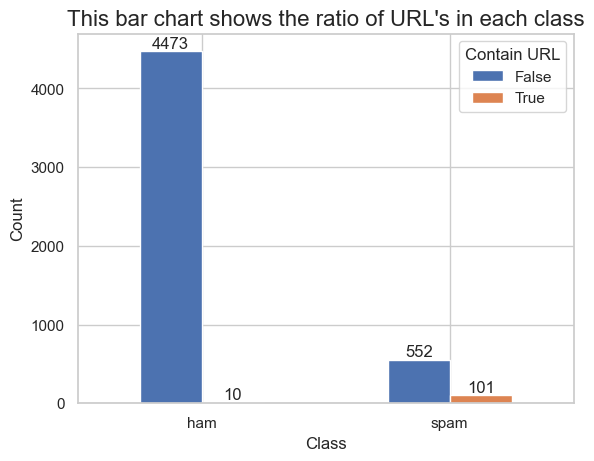

In [272]:
# Assuming class_and_url is your DataFrame or Series
plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_url.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of URL's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing phone number

In [273]:
class_and_phone = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain Phone Number'])

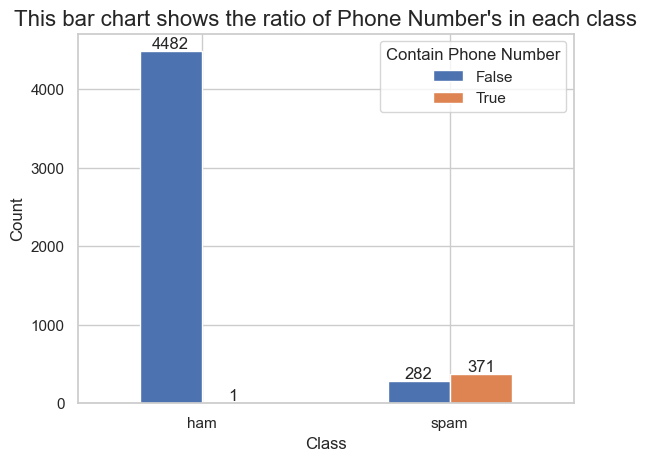

In [274]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_phone.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing email

In [275]:
class_and_email = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain Email'])

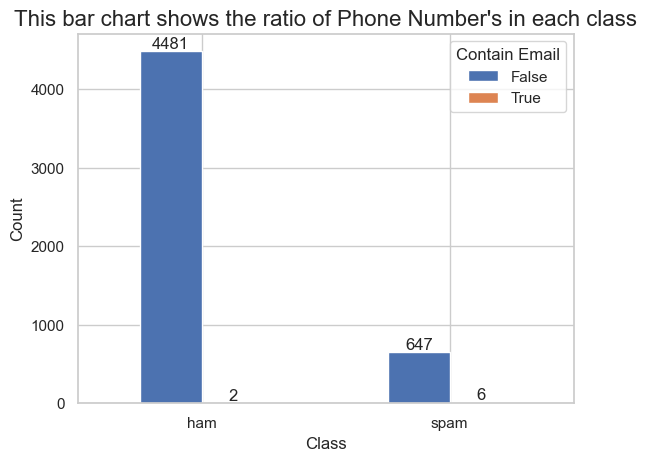

In [276]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_email.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing currency symbol

In [277]:
class_and_currency = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain Currency Symbol'])

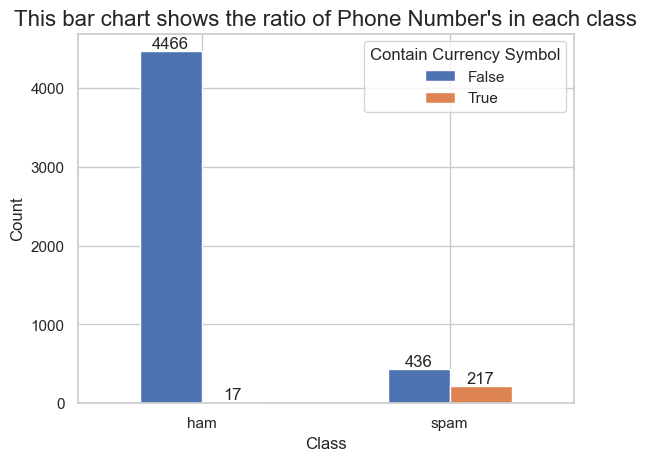

In [278]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_currency.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing HTML

In [279]:
class_and_html = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain HTML'])

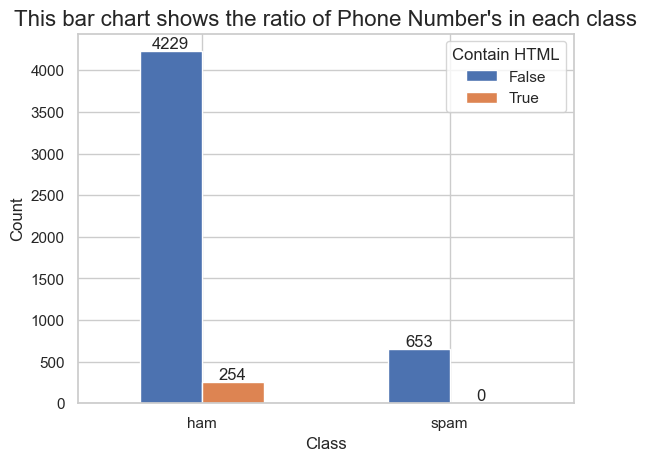

In [280]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_html.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing special characters

In [281]:
class_and_scharacter = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain Special Character'])

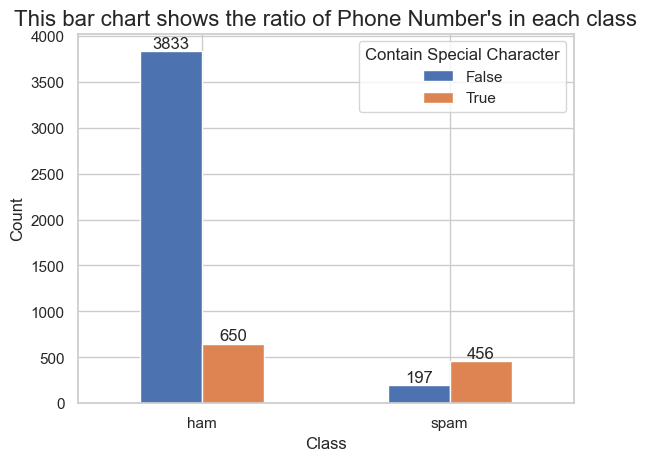

In [282]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_scharacter.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

# Text Preprocessing

In [283]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [284]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Message']

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\41747405.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Removing the HTML entities

In [285]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: html_entity_pattern.sub('', x))

In [286]:
df_cleaned[df_cleaned['Contain HTML'] == True][['Message', 'Cleaned']]

,Message,Cleaned
28,"I'm back &amp; we're packing the car now, I'll let you know if there's room","I'm back we're packing the car now, I'll let you know if there's room"
44,Great! I hope you like your man well endowed. I am &lt;#&gt; inches...,Great! I hope you like your man well endowed. I am # inches...
51,"A gram usually runs like &lt;#&gt; , a half eighth is smarter though and gets you almost a whole second gram for &lt;#&gt;","A gram usually runs like # , a half eighth is smarter though and gets you almost a whole second gram for #"
55,Do you know what Mallika Sherawat did yesterday? Find out now @ &lt;URL&gt;,Do you know what Mallika Sherawat did yesterday? Find out now @ URL
78,Does not operate after &lt;#&gt; or what,Does not operate after # or what
...,...,...
5107,Wait . I will msg after &lt;#&gt; min.,Wait . I will msg after # min.
5115,Yes. Please leave at &lt;#&gt; . So that at &lt;#&gt; we can leave,Yes. Please leave at # . So that at # we can leave
5143,"I'm taking derek &amp; taylor to walmart, if I'm not back by the time you're done just leave the mouse on my desk and I'll text you when priscilla's ready","I'm taking derek taylor to walmart, if I'm not back by the time you're done just leave the mouse on my desk and I'll text you when priscilla's ready"
5155,No. I meant the calculation is the same. That &lt;#&gt; units at &lt;#&gt; . This school is really expensive. Have you started practicing your accent. Because its important. And have you decided if you are doing 4years of dental school or if you'll just do the nmde exam.,No. I meant the calculation is the same. That # units at # . This school is really expensive. Have you started practicing your accent. Because its important. And have you decided if you are doing 4years of dental school or if you'll just do the nmde exam.


## Removing email

In [287]:
df_cleaned

,Class,Message,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML,Contain Special Character,Cleaned
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,False,False,False,False,0,False,False,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...,29,False,False,False,False,0,False,False,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,False,True,False,False,0,False,True,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...,49,False,False,False,False,0,False,False,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,False,False,False,False,0,False,False,"Nah I don't think he goes to usf, he lives around here though"
...,...,...,...,...,...,...,...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",160,False,True,False,True,1,False,True,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5165,ham,Will ü b going to esplanade fr home?,36,False,False,False,False,0,False,True,Will ü b going to esplanade fr home?
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,False,False,False,False,0,False,True,"Pity, * was in mood for that. So...any other suggestions?"
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,False,False,False,False,0,False,False,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


In [288]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: email_pattern.sub('', x))

In [289]:
df_cleaned[df_cleaned['Contain Email'] == True][['Message', 'Cleaned']]

,Message,Cleaned
135,I only haf msn. It's yijue@hotmail.com,I only haf msn. It's
1562,RT-KIng Pro Video Club>> Need help? info@ringtoneking.co.uk or call 08701237397 You must be 16+ Club credits redeemable at www.ringtoneking.co.uk! Enjoy!,RT-KIng Pro Video Club>> Need help? or call 08701237397 You must be 16+ Club credits redeemable at www.ringtoneking.co.uk! Enjoy!
2221,"tddnewsletter@emc1.co.uk (More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith..","(More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith.."
2439,"Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions: info@txt82228.co.uk","Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions:"
2531,"Em, its olowoyey@ usc.edu have a great time in argentina. Not sad about secretary, everything is a blessing","Em, its have a great time in argentina. Not sad about secretary, everything is a blessing"
3303,Dorothy@kiefer.com (Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..,(Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..
4574,Warner Village 83118 C Colin Farrell in SWAT this wkend @Warner Village & get 1 free med. Popcorn!Just show msg+ticket@kiosk.Valid 4-7/12. C t&c @kiosk. Reply SONY 4 mre film offers,Warner Village 83118 C Colin Farrell in SWAT this wkend @Warner Village & get 1 free med. Popcorn!Just show 4-7/12. C t&c @kiosk. Reply SONY 4 mre film offers
4756,This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to customersqueries@netvision.uk.com,This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to


## Removing URL

In [290]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: url_pattern.sub('', x))

In [291]:
df_cleaned[df_cleaned['Contain URL'] == True][['Message', 'Cleaned']]

,Message,Cleaned
12,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18","URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C LCCLTD POBOX 4403LDNW1A7RW18"
15,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL","XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap."
189,Are you unique enough? Find out from 30th August. www.areyouunique.co.uk,Are you unique enough? Find out from 30th August..uk
221,"500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY £1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18","500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY £1 2optout 087187262701.50gbp/mtmsg18"
246,Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16,Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs1win150ppmx3age16
...,...,...
4919,XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC www.Ldew.com1win150ppmx3age16subscription,XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC1win150ppmx3age16subscription
5069,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit.uk
5072,Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop www.gamb.tv,Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop
5076,http//tms. widelive.com/index. wml?id=820554ad0a1705572711&first=true¡C C Ringtone¡,http//tms. wml?id=820554ad0a1705572711&first=true¡C C Ringtone¡


## Remove phone number

In [292]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: phone_pattern.sub('', x))

In [293]:
df_cleaned[df_cleaned['Contain Phone Number'] == True][['Message', 'Cleaned']]

,Message,Cleaned
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply over18's
8,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call . Claim code KL341. Valid 12 hours only.
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on
42,07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow,- Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now for delivery tomorrow
56,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!","Congrats! 1 year special cinema pass for 2 is yours. call now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!"
...,...,...
5093,2p per min to call Germany 08448350055 from your BT line. Just 2p per min. Check PlanetTalkInstant.com for info & T's & C's. Text stop to opt out,2p per min to call Germany from your BT line. Just 2p per min. Check for info & T's & C's. Text stop to opt out
5104,PRIVATE! Your 2003 Account Statement for 07808247860 shows 800 un-redeemed S. I. M. points. Call 08719899229 Identifier Code: 40411 Expires 06/11/04,PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call Identifier Code: 40411 Expires 06/11/04
5127,PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points. Call 08718738001 Identifier Code: 49557 Expires 26/11/04,PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points. Call Identifier Code: 49557 Expires 26/11/04
5137,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,Want explicit SEX in 30 secs? Ring now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX


## Removing punctuations

In [294]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [295]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [296]:
df_cleaned[['Message', 'Cleaned']].head(8)

,Message,Cleaned
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat
1,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005 Text FA to 87121 to receive entry questionstd txt rateTCs apply over18s
3,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,"Nah I don't think he goes to usf, he lives around here though",Nah I dont think he goes to usf he lives around here though
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",FreeMsg Hey there darling its been 3 weeks now and no word back Id like some fun you up for it still Tb ok XxX std chgs to send £150 to rcv
6,Even my brother is not like to speak with me. They treat me like aids patent.,Even my brother is not like to speak with me They treat me like aids patent
7,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,As per your request Melle Melle Oru Minnaminunginte Nurungu Vettam has been set as your callertune for all Callers Press 9 to copy your friends Callertune


## Remove number

In [297]:
number_pattern = re.compile(r'\b\w*\d+\w*\b')
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: number_pattern.sub('', x))

In [298]:
df_cleaned[['Message', 'Cleaned']].head(8)

,Message,Cleaned
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat
1,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,Free entry in a wkly comp to win FA Cup final tkts May Text FA to to receive entry questionstd txt rateTCs apply
3,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,"Nah I don't think he goes to usf, he lives around here though",Nah I dont think he goes to usf he lives around here though
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",FreeMsg Hey there darling its been weeks now and no word back Id like some fun you up for it still Tb ok XxX std chgs to send £ to rcv
6,Even my brother is not like to speak with me. They treat me like aids patent.,Even my brother is not like to speak with me They treat me like aids patent
7,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,As per your request Melle Melle Oru Minnaminunginte Nurungu Vettam has been set as your callertune for all Callers Press to copy your friends Callertune


## Tokenization

In [299]:
df_cleaned.loc[:,'Tokenized'] = df_cleaned['Cleaned'].apply(lambda x: word_tokenize(x.lower()))

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\1210549041.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [300]:
df_cleaned[['Cleaned', 'Tokenized']].head(8)

,Cleaned,Tokenized
0,Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]"
1,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,Free entry in a wkly comp to win FA Cup final tkts May Text FA to to receive entry questionstd txt rateTCs apply,"[free, entry, in, a, wkly, comp, to, win, fa, cup, final, tkts, may, text, fa, to, to, receive, entry, questionstd, txt, ratetcs, apply]"
3,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, then, say]"
4,Nah I dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]"
5,FreeMsg Hey there darling its been weeks now and no word back Id like some fun you up for it still Tb ok XxX std chgs to send £ to rcv,"[freemsg, hey, there, darling, its, been, weeks, now, and, no, word, back, id, like, some, fun, you, up, for, it, still, tb, ok, xxx, std, chgs, to, send, £, to, rcv]"
6,Even my brother is not like to speak with me They treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]"
7,As per your request Melle Melle Oru Minnaminunginte Nurungu Vettam has been set as your callertune for all Callers Press to copy your friends Callertune,"[as, per, your, request, melle, melle, oru, minnaminunginte, nurungu, vettam, has, been, set, as, your, callertune, for, all, callers, press, to, copy, your, friends, callertune]"


## Removing stop words

In [301]:
print(stop_words)

{'what', "couldn't", 'myself', 'shan', 'against', 'we', 'didn', 'doing', 'both', 'your', 'hasn', 'of', 'here', 'wasn', 'ours', 'an', 'to', 'being', 'only', 'where', 'herself', 'whom', 'off', 'if', "mightn't", 'same', 'is', 'she', 'then', 'was', 'mightn', 'because', 'or', 'for', 'he', "that'll", 'not', 'below', 'all', 'why', 'and', 'his', 've', 'now', 'have', "shan't", 'these', 'after', 'when', 'm', "hadn't", 'at', "wasn't", 'once', 're', 'yourself', "haven't", 'doesn', "won't", 'can', 'while', "isn't", 'how', 'down', "didn't", 'no', 'theirs', 'himself', 'her', 'just', 'until', 'hadn', 'such', "shouldn't", 'with', 'any', 't', "she's", 'you', 'them', 'are', 'before', 'so', 'isn', 'don', 'each', 'needn', 'be', 'were', 'd', 'wouldn', 'themselves', 'am', 'between', 'shouldn', 'into', 'had', "wouldn't", 'do', 'hers', 'very', 'in', 'me', 'they', 's', 'its', "mustn't", 'my', "hasn't", 'aren', 'yourselves', 'that', 'mustn', "it's", "you're", 'ain', 'few', 'haven', 'did', 'some', 'about', 'o', '

In [302]:
df_cleaned.loc[:,'Preprocessed'] = df_cleaned['Tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\1483153977.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [303]:
df_cleaned[['Tokenized', 'Preprocessed']].head(8)

,Tokenized,Preprocessed
0,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,"[free, entry, in, a, wkly, comp, to, win, fa, cup, final, tkts, may, text, fa, to, to, receive, entry, questionstd, txt, ratetcs, apply]","[free, entry, wkly, comp, win, fa, cup, final, tkts, may, text, fa, receive, entry, questionstd, txt, ratetcs, apply]"
3,"[u, dun, say, so, early, hor, u, c, already, then, say]","[u, dun, say, early, hor, u, c, already, say]"
4,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives, around, though]"
5,"[freemsg, hey, there, darling, its, been, weeks, now, and, no, word, back, id, like, some, fun, you, up, for, it, still, tb, ok, xxx, std, chgs, to, send, £, to, rcv]","[freemsg, hey, darling, weeks, word, back, id, like, fun, still, tb, ok, xxx, std, chgs, send, £, rcv]"
6,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]"
7,"[as, per, your, request, melle, melle, oru, minnaminunginte, nurungu, vettam, has, been, set, as, your, callertune, for, all, callers, press, to, copy, your, friends, callertune]","[per, request, melle, melle, oru, minnaminunginte, nurungu, vettam, set, callertune, callers, press, copy, friends, callertune]"


## Lemmatization

In [304]:
df_cleaned.loc[:,'Preprocessed'] = df_cleaned['Preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [305]:
df_cleaned[['Tokenized', 'Preprocessed']].head(8)

,Tokenized,Preprocessed
0,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,"[free, entry, in, a, wkly, comp, to, win, fa, cup, final, tkts, may, text, fa, to, to, receive, entry, questionstd, txt, ratetcs, apply]","[free, entry, wkly, comp, win, fa, cup, final, tkts, may, text, fa, receive, entry, questionstd, txt, ratetcs, apply]"
3,"[u, dun, say, so, early, hor, u, c, already, then, say]","[u, dun, say, early, hor, u, c, already, say]"
4,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, go, usf, life, around, though]"
5,"[freemsg, hey, there, darling, its, been, weeks, now, and, no, word, back, id, like, some, fun, you, up, for, it, still, tb, ok, xxx, std, chgs, to, send, £, to, rcv]","[freemsg, hey, darling, week, word, back, id, like, fun, still, tb, ok, xxx, std, chgs, send, £, rcv]"
6,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aid, patent]"
7,"[as, per, your, request, melle, melle, oru, minnaminunginte, nurungu, vettam, has, been, set, as, your, callertune, for, all, callers, press, to, copy, your, friends, callertune]","[per, request, melle, melle, oru, minnaminunginte, nurungu, vettam, set, callertune, caller, press, copy, friend, callertune]"


# Vectorization

## Creating TF-IDF matrix

In [306]:
df_cleaned.loc[:,'Preprocessed'] = df_cleaned['Preprocessed'].apply(lambda x: ' '.join(x))

In [307]:
df_cleaned['Preprocessed']

0                       go jurong point crazy available bugis n great world la e buffet cine got amore wat
1                                                                                  ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts may text fa receive entry questionstd txt ratetcs apply
3                                                                      u dun say early hor u c already say
4                                                                 nah dont think go usf life around though
                                                       ...                                                
5164                        time tried contact u u £ pound prize claim easy call per minute btnationalrate
5165                                                                           ü b going esplanade fr home
5166                                                                            pity mood soany suggestion
5167                     guy bitching

In [308]:
vectorizer = TfidfVectorizer(strip_accents='ascii', max_features=1000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(df_cleaned['Preprocessed'])

In [309]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [310]:
df_tfidf

,abiola,able,abt,account,account statement,across,across sea,actually,add,address,...,yep,yes,yesterday,yet,yo,youll,youre,youve,yr,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [311]:
df_tfidf[df_tfidf['account'] > 0]

,abiola,able,abt,account,account statement,across,across sea,actually,add,address,...,yep,yes,yesterday,yet,yo,youll,youre,youve,yr,yup
119,0.0,0.0,0.0,0.210298,0.236639,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.0,0.0,0.0,0.328651,0.000000,0.0,0.0,0.0,0.0,0.354965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200,0.0,0.0,0.0,0.635308,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,0.0,0.0,0.0,0.562481,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
482,0.0,0.0,0.0,0.275770,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
522,0.0,0.0,0.0,0.212190,0.238768,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
583,0.0,0.0,0.0,0.212190,0.238768,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.212190,0.238768,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700,0.0,0.0,0.0,0.641736,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
846,0.0,0.0,0.0,0.218923,0.246344,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating a matrix for binary columns

In [312]:
additional_features = df_cleaned[['Contain URL', 'Contain Phone Number', 'Contain Currency Symbol']].astype(int)
additional_features

,Contain URL,Contain Phone Number,Contain Currency Symbol
0,0,0,0
1,0,0,0
2,0,1,0
3,0,0,0
4,0,0,0
...,...,...,...
5164,0,1,1
5165,0,0,0
5166,0,0,0
5167,0,0,0


In [313]:
df_tfidf.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)
df_matrix = pd.concat([df_tfidf, additional_features], axis=1)

In [314]:
df_matrix

,abiola,able,abt,account,account statement,across,across sea,actually,add,address,...,yet,yo,youll,youre,youve,yr,yup,Contain URL,Contain Phone Number,Contain Currency Symbol
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
5132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
5133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
5134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


## SMOTE

In [315]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Encode the 'Class' column
label_encoder = LabelEncoder()
df_cleaned['Class'] = label_encoder.fit_transform(df_cleaned['Class'])

# Separate features and target variable
# y = df_cleaned['Class']

# Convert the text data into numerical data using TF-IDF Vectorizer
# tfidf = TfidfVectorizer()
# X_tfidf = tfidf.fit_transform(X)

# Apply SMOTE to the entire dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_matrix, df_cleaned['Class'])

# Check the class distribution after SMOTE
# print("Original class distribution:", pd.Series(y).value_counts())
# print("Resampled class distribution:", pd.Series(y_resampled).value_counts())

# Convert the resampled features back to a DataFrame with the original message column names
# X_resampled_df = pd.DataFrame(X_resampled.toarray(), columns=tfidf.get_feature_names_out())

# Inverse transform the labels to get the original class names
# y_resampled_labels = label_encoder.inverse_transform(y_resampled)

# Create the new DataFrame with the same format as the original dataset
# resampled_df = X_resampled_df.copy()
# resampled_df['Class'] = y_resampled_labels

# Convert the resampled messages back to text (optional step)
# resampled_df['Message'] = [' '.join(word_list) for word_list in tfidf.inverse_transform(X_resampled)]

# Show the resampled DataFrame (first few rows)
# print(resampled_df.head())

# resampled_df_final = resampled_df[['Class', 'Message']]
# print(resampled_df_final.shape)
# print(resampled_df_final.head())

# The final DataFrame with the original class labels
#df_smote = resampled_df_final


C:\Users\ashut\AppData\Local\Temp\ipykernel_57488\1724734778.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [316]:
X_resampled

,abiola,able,abt,account,account statement,across,across sea,actually,add,address,...,yet,yo,youll,youre,youve,yr,yup,Contain URL,Contain Phone Number,Contain Currency Symbol
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
8962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
8963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
8964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


# Training Model

## Train Test Split

In [317]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled,y_resampled,test_size=0.3)

In [318]:
X_train

,abiola,able,abt,account,account statement,across,across sea,actually,add,address,...,yet,yo,youll,youre,youve,yr,yup,Contain URL,Contain Phone Number,Contain Currency Symbol
6848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
5180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
8952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
6272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
4137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [319]:
X_train[X_train['Contain URL'] == 1]

,abiola,able,abt,account,account statement,across,across sea,actually,add,address,...,yet,yo,youll,youre,youve,yr,yup,Contain URL,Contain Phone Number,Contain Currency Symbol
3331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
6493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
8843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
5476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
7772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
4764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
5658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
6355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1


## Multinomial Naive Bayes

In [320]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train, Y_train)

MultinomialNB()

## Complement Naive Bayes

In [321]:
cnb_model = ComplementNB()
cnb_model.fit(X_train, Y_train)

ComplementNB()

## Logistic Regression

In [322]:
lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)

LogisticRegression()

# Predicting

In [323]:
Y_pred_lr = lr_model.predict(X_test)
Y_pred_mnb = mnb_model.predict(X_test)
Y_pred_cnb = cnb_model.predict(X_test)

Y_pred_prob_lr = lr_model.predict_proba(X_test)
Y_pred_prob_mnb = mnb_model.predict_proba(X_test)
Y_pred_prob_cnb = cnb_model.predict_proba(X_test)

# Evaluation

In [324]:
def evaluate(title, Y_test, Y_pred, Y_pred_prob):
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob[:, 1])
    roc_auc = roc_auc_score(Y_test, Y_pred_prob[:, 1])
    precision_prob, recall_prob, _ = precision_recall_curve(Y_test, Y_pred_prob[:, 1])
    pr_auc = auc(recall_prob, precision_prob)

    fig = plt.figure(figsize=(15,5))
    fig.suptitle(title, fontsize=30)

    # Confusion Matrix
    plt.subplot(1,3,1)
    cm = confusion_matrix(Y_test, Y_pred)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(cm, annot=True, fmt='d', cmap=colormap, xticklabels=['Predicted Ham', 'Predicted Spam'], yticklabels=['Actual Ham', 'Actual Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # ROC Curve
    plt.subplot(1,3,2)
    plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # PR-AUC
    plt.subplot(1,3,3)
    plt.plot(recall_prob, precision_prob, color='purple', label=f'PR AUC = {pr_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show

    data = [accuracy, precision, recall, f1, roc_auc, pr_auc]
    indices = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC']
    columns = [title]
    return pd.DataFrame(data, index=indices, columns=columns)

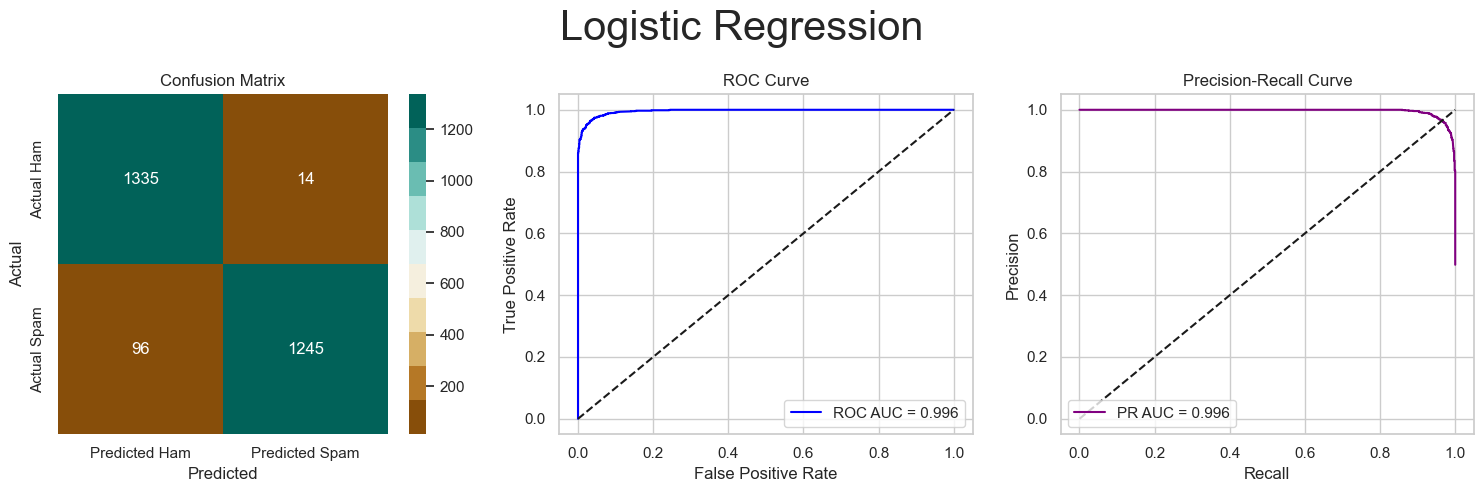

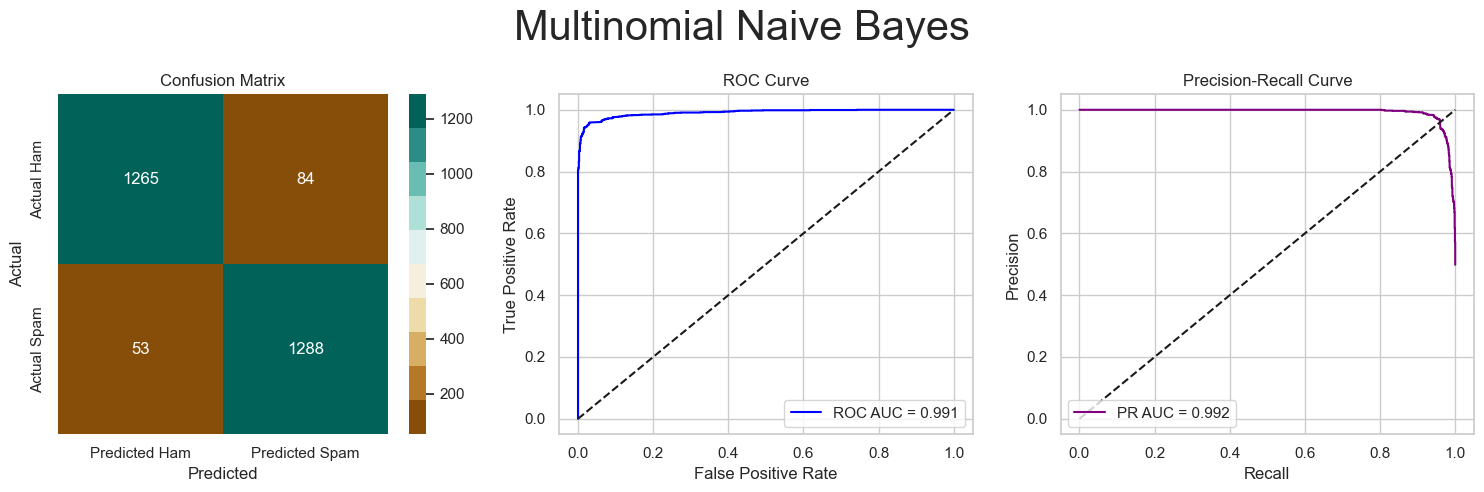

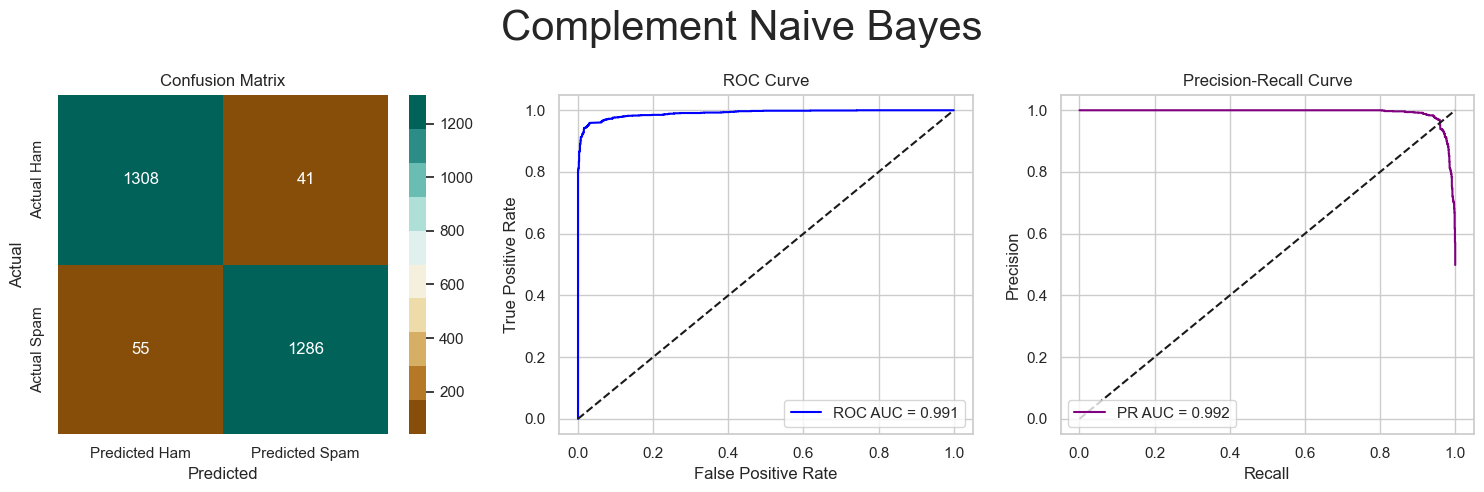

In [325]:
lr_perf = evaluate('Logistic Regression', Y_test, Y_pred_lr, Y_pred_prob_lr)
mnb_perf = evaluate('Multinomial Naive Bayes', Y_test, Y_pred_mnb, Y_pred_prob_mnb)
cnb_perf = evaluate('Complement Naive Bayes', Y_test, Y_pred_cnb, Y_pred_prob_cnb)
plt.show()

In [326]:
perf_comparision = pd.concat([lr_perf, mnb_perf, cnb_perf], axis=1)
perf_comparision

,Logistic Regression,Multinomial Naive Bayes,Complement Naive Bayes
Accuracy,0.959108,0.949071,0.964312
Precision,0.988880,0.938776,0.969103
Recall,0.928412,0.960477,0.958986
F1,0.957692,0.949502,0.964018
ROC-AUC,0.995946,0.990821,0.990821
PR-AUC,0.996137,0.992422,0.992422


# Tuning the models

## Find the best parameters

### Logistic Regression

In [327]:
lr_param = {
    'C': [i / 10 for i in range(1, 101)], 
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': [None, 'balanced'],
}
random_search = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=lr_param, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42, scoring='f1')
random_search.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                              0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,
                                              1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1,
                                              2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
                                              2.9, 3.0, ...],
                                        'class_weight': [None, 'balanced'],
                                        'solver': ['liblinear', 'lbfgs']},
                   random_state=42, scoring='f1', verbose=1)

In [328]:
lr_best_param = random_search.best_params_

### Multinomial Naive Bayes

In [329]:
mnb_param = {
    'alpha': [i / 10 for i in range(1, 101)],
    'fit_prior': [True, False],
}
random_search = RandomizedSearchCV(estimator=MultinomialNB(), param_distributions=mnb_param, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42, scoring='f1')
random_search.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                                  1.9, 2.0, 2.1, 2.2, 2.3, 2.4,
                                                  2.5, 2.6, 2.7, 2.8, 2.9, 3.0, ...],
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='f1', verbose=1)

In [330]:
mnb_best_param = random_search.best_params_

### Complement Naive Bayes

In [331]:
cnb_param = {
    'alpha': [i / 10 for i in range(1, 101)],
    'fit_prior': [True, False],
    'norm': [True, False]
}
random_search = RandomizedSearchCV(estimator=ComplementNB(), param_distributions=cnb_param, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42, scoring='f1')
random_search.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=ComplementNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                                  1.9, 2.0, 2.1, 2.2, 2.3, 2.4,
                                                  2.5, 2.6, 2.7, 2.8, 2.9, 3.0, ...],
                                        'fit_prior': [True, False],
                                        'norm': [True, False]},
                   random_state=42, scoring='f1', verbose=1)

In [332]:
cnb_best_param = random_search.best_params_

## Retrain the model with best parameters

### Logistic Regression

In [333]:
lr_model = LogisticRegression(**lr_best_param)
lr_model.fit(X_train, Y_train)

LogisticRegression(C=8.4, class_weight='balanced')

### Multinomial Naive Bayes

In [334]:
mnb_model = MultinomialNB(**mnb_best_param)
mnb_model.fit(X_train, Y_train)

MultinomialNB(alpha=0.3, fit_prior=False)

### Complement Naive Bayes

In [335]:
cnb_model = ComplementNB(**cnb_best_param)
cnb_model.fit(X_train, Y_train)

ComplementNB(alpha=0.1, fit_prior=False)

## Reevaluate with the test dataset

In [336]:
Y_pred_lr = lr_model.predict(X_test)
Y_pred_mnb = mnb_model.predict(X_test)
Y_pred_cnb = cnb_model.predict(X_test)

Y_pred_prob_lr = lr_model.predict_proba(X_test)
Y_pred_prob_mnb = mnb_model.predict_proba(X_test)
Y_pred_prob_cnb = cnb_model.predict_proba(X_test)

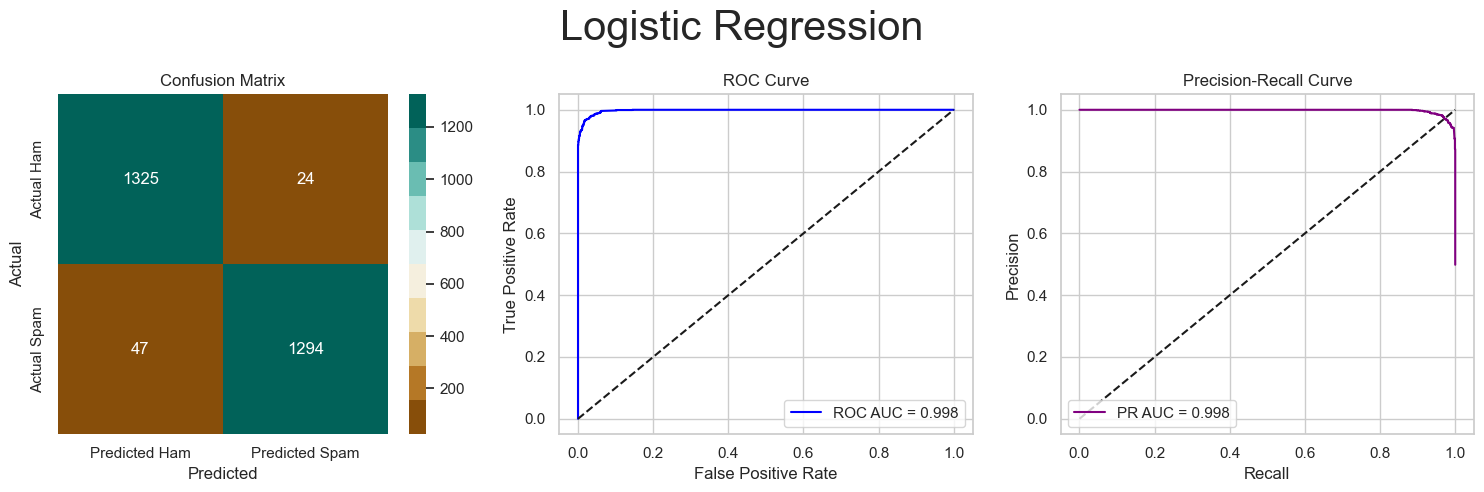

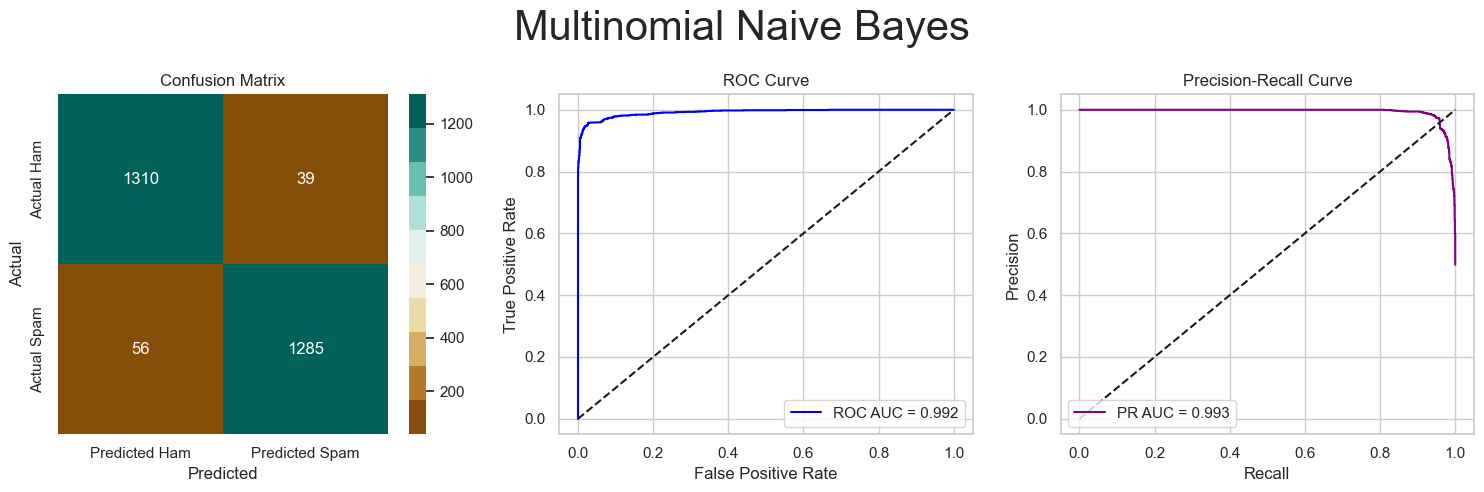

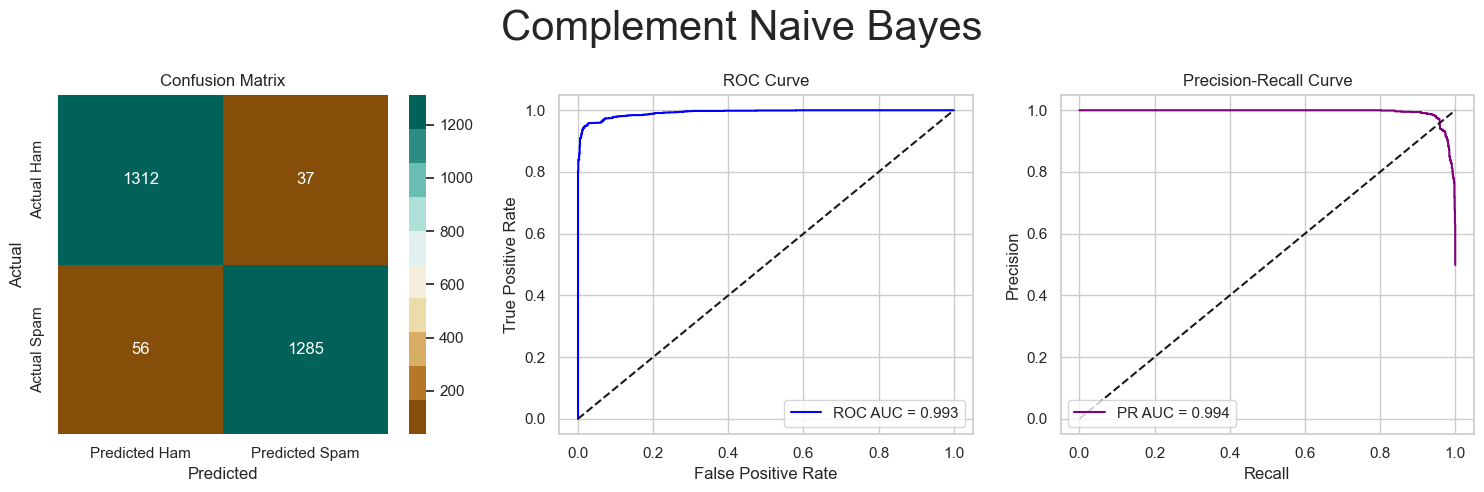

In [337]:
lr_perf = evaluate('Logistic Regression', Y_test, Y_pred_lr, Y_pred_prob_lr)
mnb_perf = evaluate('Multinomial Naive Bayes', Y_test, Y_pred_mnb, Y_pred_prob_mnb)
cnb_perf = evaluate('Complement Naive Bayes', Y_test, Y_pred_cnb, Y_pred_prob_cnb)
plt.show()

In [338]:
perf_comparision = pd.concat([lr_perf, mnb_perf, cnb_perf], axis=1)
perf_comparision

,Logistic Regression,Multinomial Naive Bayes,Complement Naive Bayes
Accuracy,0.973606,0.964684,0.965428
Precision,0.981791,0.970544,0.972012
Recall,0.964952,0.958240,0.958240
F1,0.973298,0.964353,0.965077
ROC-AUC,0.997791,0.991970,0.992724
PR-AUC,0.997820,0.993167,0.993653
